In [404]:
from pandas import read_csv
import numpy as np
from matplotlib.pyplot import hist, show, scatter
from numpy import mean, min, max, median, quantile
from scipy.stats import binom, norm, t as student
from math import sqrt, pow, floor, ceil, exp

In [405]:
data = 'data'
data_ex1 = f'{data}\\data_ex1.csv'

ex1 = read_csv(data_ex1, header=None)
values = ex1.to_numpy()[:, 0]
values = sorted(values)

In [406]:
# define corrected functions for std and variance
def variance(values):
    return np.var(values, ddof=1)
def std(values):
    return np.std(values, ddof=1)

In [407]:
def quantile_confidence(values, q, confidence):
    # return tuple (lower, upper) of values
    values = sorted(values)
    n = len(values)
    if n > 100:
        # approximate
        z = norm.ppf((1+confidence)/2)
        j = floor(n*q-z*sqrt(n*q*(1-q)))
        k = ceil(n*q+z*sqrt(n*q*(1-q)))+1
        return (values[j], values[k], confidence)

    results = []
    binoms = [binom.cdf(i, n, q) for i in range(0, n)]
    for j in range(1, n):
        for k in range(j, n):
            val = binoms[k] - binoms[j]
            if val >= confidence:
                results.append((j, k, val))

    # sort by smallest interval and highest confidence value
    results = sorted(results, key=lambda x: (x[1]-x[0], -x[2]))
    best = results[0]
    return (values[best[0]], values[best[1]])


In [408]:
print("Median:", median(values))
interval = quantile_confidence(values, 0.5, 0.95)
print(f"CI at 0.95: [{interval[0]} , {interval[1]}]")

Median: 0.40319100366316096
CI at 0.95: [0.384475528575523 , 0.4171819583272271]


In [409]:
def mean_confidence_asymptotic(values, confidence):
    # when variables iid and high n
    n = len(values)
    z = norm.ppf((1+confidence)/2)
    s = std(values)
    m = mean(values)
    j = m - z*s/sqrt(n)
    k = m + z*s/sqrt(n)
    return (j, k)

In [410]:
# 1000 iid values => asymptotic
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]")

Mean: 0.41020458058272363
Mean CI at 0.95: [0.398868829144219 , 0.42154033202122826]
Mean CI at 0.99: [0.3953068778885086 , 0.42510228327693866]


In [411]:
data_ex2 = f'{data}\\data_ex2.csv'
ex2 = read_csv(data_ex2, header=None)
rows = ex2.to_numpy()

In [412]:
# 200 values => asymptotic again
values = rows[0]
print("var", variance(values))
print(f"Mean: {mean(values)}")
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")

var 2.938079099198786
Mean: 3.175048214082969
Mean CI at 0.95: [2.9374928534666043 , 3.4126035746993337]


In [413]:
outside = 0
inside = 0
for i in range(1, 6001):
    m = mean(rows[i])
    if m >= interval[0] and m <= interval[1]:
        inside += 1
    else:
        outside += 1

print(f"Ratio of rows with mean inside CI 0.95: {inside/(inside+outside)}")

Ratio of rows with mean inside CI 0.95: 0.6693333333333333


In [414]:
data_ex3 = f'{data}\\data_ex3.csv'
ex3 = read_csv(data_ex3, header=None)
values = ex3.to_numpy()[:,0]
values = sorted(values)

In [415]:
def CoV(values):
    # Coeff of variation (not defined on heavy tailed sets, because variance=>inf)
    return std(values)/mean(values)

def MAD(values):
    # mean absolute deviation, always defined
    n = len(values)
    m = mean(values)
    return sum([abs(x-m) for x in values])/n

def lorenz_gap(values):
    # always defined, the best
    return MAD(values)/(2*mean(values))

def JFI(values):
    # Jain Fairness Index (same problems as CoV?)
    return 1/(1+pow(CoV(values), 2))

In [416]:
print(f"CoV: {CoV(values)}")
print(f"Lorenz gap: {lorenz_gap(values)}")
print(f"Jain FI: {JFI(values)}")

CoV: 1.001469136252603
Lorenz gap: 0.36230444707595705
Jain FI: 0.49926597146344925


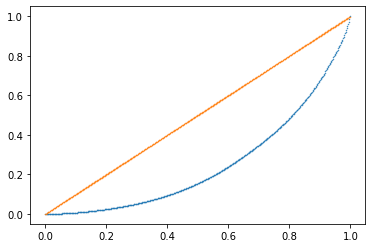

In [417]:
# plot lorenz
n = len(values)
curve = []
line = []
tot = sum(values)
cum_sum = np.cumsum(values)
for i in np.arange(0, n, 1):
    line.append(i/n)
    curve.append(cum_sum[i]/tot)

scatter(line, curve, s=0.2)
scatter(line, line, s=0.2)
show()

In [418]:

def bootstrap(values, confidence, func, r0=25):
    R = ceil(2*r0/(1-confidence))
    n = len(values)
    Tvs = []
    for r in range(R):
        V = np.random.choice(values, size=(n,))
        Tv = func(V)
        Tvs.append(Tv)
    Tvs = sorted(Tvs)
    interval = (Tvs[r0], Tvs[R-r0-1])
    low = 0
    high = 0
    for tv in Tvs:
        if tv < interval[0]:
            low += 1
        if tv > interval[1]:
            high += 1
    return interval

print(f"Lorenz gap: {lorenz_gap(values)}")
interval = bootstrap(values, 0.95, lorenz_gap)
print(f"Lorenz gap CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, lorenz_gap)
print(f"Lorenz gap CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Jain FI: {JFI(values)}")
interval = bootstrap(values, 0.95, JFI)
print(f"Jain FI CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, JFI)
print(f"Jain FI CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Mean: {mean(values)}")
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]\n")

print(f"Std: {std(values)}")
interval = bootstrap(values, 0.95, std)
print(f"Std CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, std)
print(f"Std CI at 0.99: [{interval[0]} , {interval[1]}]\n")

Lorenz gap: 0.36230444707595705
Lorenz gap CI at 0.95: [0.34068567205709 , 0.38579950877612795]
Lorenz gap CI at 0.99: [0.33388522512320107 , 0.390150882221583]

Jain FI: 0.49926597146344925
Jain FI CI at 0.95: [0.45924303435519664 , 0.543111558153176]
Jain FI CI at 0.99: [0.4455365359864541 , 0.5593960881378675]

Mean: 4.084097581606042
Mean CI at 0.95: [3.7409342701694257 , 4.478429380177676]
Mean CI at 0.99: [3.6183435034177083 , 4.5771497571681685]

Std: 4.090097677422348
Std CI at 0.95: [3.5717793414834493 , 4.59562691560814]
Std CI at 0.99: [3.451963844555665 , 4.781394927240428]



In [419]:
# compare bootstrap mean with asymptotic mean
interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99: [{interval[0]} , {interval[1]}]\n")

# bootstrap has smaller interval

Mean CI at 0.95: [3.7255913008639814 , 4.442603862348103]
Mean CI at 0.99: [3.612940463043766 , 4.555254700168319]



In [420]:
data_ex4 = f'{data}\\data_ex4.csv'
ex4 = read_csv(data_ex4, header=None)
values = ex4.to_numpy()[:,0]
values = sorted(values)

# compare bootstrap and asymptotic
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95 using bootstrap: [{interval[0]} , {interval[1]}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99 using bootstrap: [{interval[0]} , {interval[1]}]\n")

interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95 using asymptotic: [{interval[0]} , {interval[1]}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99 using asymptotic: [{interval[0]} , {interval[1]}]\n")



Mean CI at 0.95 using bootstrap: [126.93162550846105 , 12087.978254806105]
Mean CI at 0.99 using bootstrap: [60.210308677112955 , 15797.044807616106]

Mean CI at 0.95 using asymptotic: [-3226.3420437613004 , 11612.994704202103]
Mean CI at 0.99 using asymptotic: [-5557.770818027488 , 13944.42347846829]



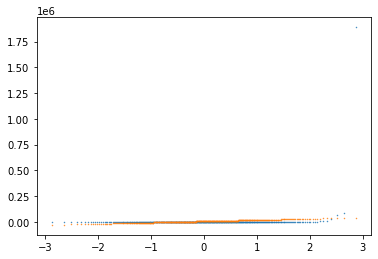

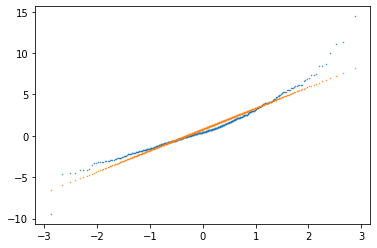

In [421]:
#plot QQ
X = []
Y = []
n = len(values)
for i in np.arange(0,n,1):
    X.append(norm.ppf((i+1)/(n+1)))
    Y.append(values[i])
X = np.array(X)
Y = np.array(Y)
m, b = np.polyfit(X, Y, 1)
scatter(X, Y, s=0.2)
scatter(X, m*X + b, s=0.2)
show()

# log transform
Y_log = np.log(values)
m, b = np.polyfit(X, Y_log, 1)
scatter(X, Y_log, s=0.2)
scatter(X, m*X + b, s=0.2)
show()

In [422]:
# compare bootstrap and asymptotic on log data
values = np.log(values)
interval = bootstrap(values, 0.95, mean)
print(f"Mean CI at 0.95 using bootstrap: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]")
interval = bootstrap(values, 0.99, mean)
print(f"Mean CI at 0.99 using bootstrap: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]\n")

interval = mean_confidence_asymptotic(values, 0.95)
print(f"Mean CI at 0.95 using asymptotic: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]")
interval = mean_confidence_asymptotic(values, 0.99)
print(f"Mean CI at 0.99 using asymptotic: [{interval[0]} , {interval[1]}], re-transformed: [{exp(interval[0])} , {exp(interval[1])}]\n")


Mean CI at 0.95 using bootstrap: [0.5989279225739924 , 1.0556053350461536], re-transformed: [1.8201663947091349 , 2.8737141874095466]
Mean CI at 0.99 using bootstrap: [0.5314885028345637 , 1.12306426877882], re-transformed: [1.7014630572216267 , 3.074260144145286]

Mean CI at 0.95 using asymptotic: [0.5924332420947909 , 1.0491151025472925], re-transformed: [1.8083833006902783 , 2.8551235083706876]
Mean CI at 0.99 using asymptotic: [0.5206833217157347 , 1.1208650229263486], re-transformed: [1.6831774085012328 , 3.0675065194365163]



In [423]:
data_ex5 = f'{data}\\data_ex5.csv'
ex5 = read_csv(data_ex5, header=None)
values = ex5.to_numpy()[0]
# success = 1, failure = 0
n_success = sum(values)
print(f'There are {n_success}>=6 successes and {len(values)-n_success}>=6 failures. We can approximate using the normal approximation')
print(f"Probability of success (mean): {mean(values)}")

def success_probability_confidence_normal(values, confidence):
    n = len(values)
    z = sum(values)
    eta = norm.ppf((1+confidence)/2)
    lower = z/n - eta/n * sqrt(z* (1 - z/n))
    upper = z/n + eta/n * sqrt(z* (1 - z/n))
    return (lower, upper)

interval = success_probability_confidence_normal(values, 0.95)
print(f"Probability CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = success_probability_confidence_normal(values, 0.99)
print(f"Probability CI at 0.99: [{interval[0]} , {interval[1]}]")

There are 125>6 successes and 875>6 failures. We can approximate using the normal approximation
Probability of success (mean): 0.125
Probability CI at 0.95: [0.10450220600861107 , 0.14549779399138893]
Probability CI at 0.99: [0.0980613323318191 , 0.1519386676681809]


In [424]:
values = ex5.to_numpy()[0][:15] # use only the first 15
# success = 1, failure = 0
n_success = sum(values)
print(f'There are {n_success} successes: we have to use the rule of three')
print(f"Probability of success (mean): {mean(values)}")

def success_probability_confidence_three(values, confidence):
    n = len(values)
    lower = 0
    upper = 1 - pow(((1-confidence)/2), 1/n)
    return (lower, upper)

interval = success_probability_confidence_three(values, 0.95)
print(f"Probability CI at 0.95: [{interval[0]} , {interval[1]}]")
interval = success_probability_confidence_three(values, 0.99)
print(f"Probability CI at 0.99: [{interval[0]} , {interval[1]}]")

There are 0 successes: we have to use the rule of three
Probability of success (mean): 0.0
Probability CI at 0.95: [0 , 0.21801936091053398]
Probability CI at 0.99: [0 , 0.2975781698474812]
